In [1]:
import os
import sys
import copy
import numpy as np
import pickle
import torch
import torchvision.models as models

from PIL import Image

from torch.autograd import Variable
from torch.nn import functional as F

In [2]:
with open("imagenet_labels.pkl", "rb") as f:
    class_name = pickle.load(f)

In [3]:
model = models.resnet18(pretrained=True)

In [4]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [5]:
import requests
# IMAGENET
img_url = "http://farm2.static.flickr.com/1131/681589138_e4b702f863.jpg"
get_img = requests.get(img_url)

open('test.png', 'wb').write(get_img.content)

79179

Target Class Number : 537 
Target Class Name : dogsled, dog sled, dog sleigh


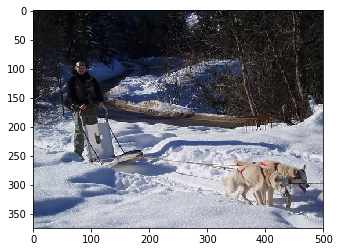

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

img_path = 'test.png'
target = 537

img = Image.open(img_path)

plt.imshow(img)

print("Target Class Number : %d \nTarget Class Name : %s" % (target, class_name[target]))

In [7]:
grads = None

def hook_function(module, grad_input, grad_output):
    global grads
    
    grads = grad_input[0]

first_layer = list(model._modules.items())[0][1]
first_layer.register_backward_hook(hook_function)

In [8]:
import torchvision.transforms as transforms
from torch.autograd import Variable

cvt_tensor = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

tensor_img = cvt_tensor(img).view(1, 3, 224, 224)
tensor_img = Variable(tensor_img, requires_grad=True)

---
# Smooth Grad

In [9]:
smooth_grad = np.zeros(tensor_img.size()[1:])

param_n = 50
param_sigma_multiplier = 5

mean = 0
sigma = param_sigma_multiplier / (torch.max(tensor_img) - torch.min(tensor_img)).item()

for x in range(param_n):
    # Generate noise
    noise = Variable(tensor_img.data.new(tensor_img.size()).normal_(mean, sigma**2))
    # Add noise to the image
    noisy_img = tensor_img + noise
    # Calculate gradients
    output = model(noisy_img)
    
    one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
    one_hot_output[0][target] = 1

    grads = None
    
    output.backward(gradient=one_hot_output)
    
    grad_img = grads[0].cpu().data.numpy()[0]
    
    # Add gradients to smooth_grad
    smooth_grad += grad_img**2
    
smooth_grad = smooth_grad / param_n

0.9985361578161288


In [10]:
def scaling(img):
    img = img - np.min(img)
    img = img / np.max(img)
    
    return img

smooth_grad_img = scaling(smooth_grad).transpose(1,2,0)

In [11]:
if np.max(smooth_grad_img) <= 1:
    smooth_grad_img = (smooth_grad_img*255).astype(np.uint8)

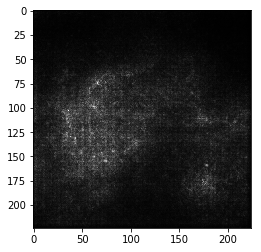

In [12]:
plt.imshow(smooth_grad_img, cmap='gray')